In [1]:
import matplotlib.pyplot as plt
import string
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.preprocessing import MinMaxScaler
from statistics import mean
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, accuracy_score, roc_auc_score

from sklearn.linear_model import LogisticRegression as LR
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier as KNC
from sklearn.tree import DecisionTreeClassifier as DTC
from sklearn.ensemble import RandomForestClassifier as RFC
from xgboost.sklearn import XGBClassifier as XGBC
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier





In [97]:
class Gesture_recognition:   
    def straightening(data):
        """
        Сшлаживает данные с датчиков.
        """
        values=[]
        middle_values=moving_average(data, n=90, istart=90)
    
   
        for x,y in zip(middle_values, data[90:-90]):
            #values.append((50-x)+y) # Старая версия. Увеличивает значения на 50. Не понятно нужно-ли.
            values.append(50-x+y)
        return values
    def moving_average(data, n=5, istart=10):
        """
        Вычисляет вектор скользящего среднего values, начиная с элемента под номеров istart и ширной окна усреднения 2*n+1. Берётся по n элементон перед и после элемента для усреднения.
        """
    
        values=[]
        for i,x in enumerate(data[n:-n]):
            values.append(sum(list(data[i+istart-n:i+istart+n]))/len(list(data[i+istart-n:i+istart+n])))
        return values 
    def time_normalization(data):

        data_new={}
        for t in data:
            data_new[t]=[]

        current_sec=0
        n=0
        for i,t in enumerate(data['second']):
            if current_sec != data['second'][i]:
                current_sec=data['second'][i].copy()
                n=0
            else:
                if n<30:
                    n+=1
                    for t in data:
                        data_new[t].append(data[t].iloc[i])
        return pd.DataFrame(data_new)
    def get_data(self):
        # Чтение данных из файлов
        self.data_Thumb = pd.read_csv('Thumb.txt', sep=';',encoding= 'unicode_escape')
        self.data_Thumb['Data1']=pd.to_numeric(self.data_Thumb['Data1'], errors='coerce')
        self.data_Thumb['Data2']=pd.to_numeric(self.data_Thumb['Data2'], errors='coerce')
        self.data_Thumb['Gesture']=pd.to_numeric(self.data_Thumb['Gesture'], errors='coerce')
        self.data_Thumb.drop(columns=['Áèîòêàíü', 'Äâèæåíèå/Æåñò', 'Êîììåíòàðèè','Data2'], inplace=True)
        self.data_Thumb.rename(columns={'Data1':'Thumb'}, inplace=True)

        self.data_Index_Middle = pd.read_csv('Index_Middle.txt', sep=';',encoding= 'unicode_escape')
        self.data_Index_Middle['Data1']=pd.to_numeric(self.data_Index_Middle['Data1'], errors='coerce')
        self.data_Index_Middle['Data2']=pd.to_numeric(self.data_Index_Middle['Data2'], errors='coerce')
        self.data_Index_Middle['Gesture']=pd.to_numeric(self.data_Index_Middle['Gesture'], errors='coerce')
        self.data_Index_Middle.drop(columns=['Áèîòêàíü', 'Äâèæåíèå/Æåñò', 'Êîììåíòàðèè'], inplace=True)
        self.data_Index_Middle.rename(columns={'Data1':'Index','Data2':'Middle',}, inplace=True)

        self.data_Ring_Little = pd.read_csv('Ring_Little.txt', sep=';',encoding= 'unicode_escape')
        self.data_Ring_Little['Data1']=pd.to_numeric(self.data_Ring_Little['Data1'], errors='coerce')
        self.data_Ring_Little['Data2']=pd.to_numeric(self.data_Ring_Little['Data2'], errors='coerce')
        self.data_Ring_Little['Gesture']=pd.to_numeric(self.data_Ring_Little['Gesture'], errors='coerce')
        self.data_Ring_Little.drop(columns=['Áèîòêàíü', 'Äâèæåíèå/Æåñò', 'Êîììåíòàðèè'], inplace=True)
        self.data_Ring_Little.rename(columns={'Data1':'Ring','Data2':'Little',}, inplace=True)  
    def time_separation(self):
        # Разделение времени
        hour   = []
        minute = []
        second = []
        time   = []

        for t in self.data_Thumb['Time']:
            time_str = t.split(sep=':')
            hour.append(int(time_str[0]))
            minute.append(int(time_str[1]))
            second.append(int(time_str[2]))
            time.append(int(time_str[0])*3600+int(time_str[1])*60+int(time_str[2]))

        self.data_Thumb['hour']   = hour
        self.data_Thumb['minute'] = minute
        self.data_Thumb['second'] = second
        self.data_Thumb['time']   = time


        hour   = []
        minute = []
        second = []
        time   = []
        for t in self.data_Index_Middle['Time']:
            time_str = t.split(sep=':')
            hour.append(int(time_str[0]))
            minute.append(int(time_str[1]))
            second.append(int(time_str[2]))
            time.append(int(time_str[0])*3600+int(time_str[1])*60+int(time_str[2]))

        
        self.data_Index_Middle['hour']   = hour
        self.data_Index_Middle['minute'] = minute
        self.data_Index_Middle['second'] = second
        self.data_Index_Middle['time']   = time

        hour   = []
        minute = []
        second = []
        time   = []
        for t in self.data_Ring_Little['Time']:
            time_str = t.split(sep=':')
            hour.append(int(time_str[0]))
            minute.append(int(time_str[1]))
            second.append(int(time_str[2]))
            time.append(int(time_str[0])*3600+int(time_str[1])*60+int(time_str[2]))
    
        self.data_Ring_Little['hour']   = hour
        self.data_Ring_Little['minute'] = minute
        self.data_Ring_Little['second'] = second
        self.data_Ring_Little['time']   = time
    def raw_data_visualization(self):
        fig1, axes = plt.subplots(5,1)
        fig1.set_size_inches(10, 15, forward=True)

        axes[0].plot(self.data_Thumb['Thumb'])
        axes[0].set_xlabel('Time')
        axes[0].set_ylabel('ADC signal')
        axes[0].set_title('Thumb')

        axes[1].plot(self.data_Index_Middle['Index'])
        axes[1].set_xlabel('Time')
        axes[1].set_ylabel('ADC signal')
        axes[1].set_title('Index')

        axes[2].plot(self.data_Index_Middle['Middle'])
        axes[2].set_xlabel('Time')
        axes[2].set_ylabel('ADC signal')
        axes[2].set_title('Middle')

        axes[3].plot(self.data_Ring_Little['Ring'])
        axes[3].set_xlabel('Time')
        axes[3].set_ylabel('ADC signal')
        axes[3].set_title('Ring')

        axes[4].plot(self.data_Ring_Little['Little'])
        axes[4].set_xlabel('Time')
        axes[4].set_title('Little')

        fig1.suptitle('ADC signal gesture \'ok\'', fontsize=16)
        fig1.tight_layout()

    def data_preparation_for_training(self):
        #Дискретизация данных по времени не постоянная в зависимоти от времени. 
        # Частота записи данных около 60 Гц. Из-за разной дискризации векторы данных 
        # с АЦП разного размера и их не возможно соединить в один dataset. 
        # time_normalization() осталвяет только первые 30 записей в каждой секунде.
        self.data_Thumb=time_normalization(self.data_Thumb)
        self.data_Index_Middle=time_normalization(self.data_Index_Middle)
        self.data_Ring_Little=time_normalization(self.data_Ring_Little)

        #В начале и и конце оборудование настраиввалось, надевалось и снималось.
        # Эти временные интервалы не должны учавтсвовать в обучении поскольку не демеотрировались жесты.
        self.data_Thumb=self.data_Thumb[self.data_Thumb['time']>60900][self.data_Thumb['time']<62400]
        self.data_Ring_Little=self.data_Ring_Little[self.data_Ring_Little['time']>60900][self.data_Ring_Little['time']<62400]
        self.data_Index_Middle=self.data_Index_Middle[self.data_Index_Middle['time']>60900][self.data_Index_Middle['time']<62400]
        self.data_Ring_Little = self.data_Ring_Little.reset_index(drop=True)
        self.data_Thumb = self.data_Thumb.reset_index(drop=True)
        self.data_Index_Middle = self.data_Index_Middle.reset_index(drop=True)

        # Объединение данных в data
        data = self.data_Ring_Little.merge(self.data_Index_Middle.drop(columns = ['Date','Time','Gesture','hour', 'minute',
                                        'second','time']), how='inner', left_index=True, right_index=True)
        data = data.merge(self.data_Thumb.drop(columns = ['Date','Time','Gesture','hour', 'minute','second','time']),
                                        how='inner', left_index=True, right_index=True)

        data=pd.DataFrame({'Ring':    straightening(data['Ring']),
                     'Little':  straightening(data['Little']),
                     'Thumb':   straightening(data['Thumb']),
                     'Middle':  straightening(data['Middle']),
                     'Index':   straightening(data['Index']),
                     'gesture': list(data_Thumb['Gesture'][90:-90])}
                   )

    def prepared_data_visualization(self):
        fig1, axes = plt.subplots(5,2)
        fig1.set_size_inches(10, 15, forward=True)

        axes[0][0].plot(data['Thumb'])
        axes[0][0].set_xlabel('Time')
        axes[0][0].set_ylabel('ADC signal')
        axes[0][0].set_title('\'Thumb\' before')

        axes[0][1].plot(data_2['Thumb'])
        axes[0][1].set_xlabel('Time')
        axes[0][1].set_ylabel('ADC signal')
        axes[0][1].set_title('\'Thumb\' after')

        axes[1][0].plot(data['Index'])
        axes[1][0].set_xlabel('Time')
        axes[1][0].set_ylabel('ADC signal')
        axes[1][0].set_title('\'Index\' before')

        axes[1][1].plot(data_2['Index'])
        axes[1][1].set_xlabel('Time')
        axes[1][1].set_ylabel('ADC signal')
        axes[1][1].set_title('\'Index\' after')

        axes[2][0].plot(data['Middle'])
        axes[2][0].set_xlabel('Time')
        axes[2][0].set_ylabel('ADC signal')
        axes[2][0].set_title('\'Middle\' before')

        axes[2][1].plot(data_2['Middle'])
        axes[2][1].set_xlabel('Time')
        axes[2][1].set_ylabel('ADC signal')
        axes[2][1].set_title('\'Middle\' after')

        axes[3][0].plot(data['Ring'])
        axes[3][0].set_xlabel('Time')
        axes[3][0].set_ylabel('ADC signal')
        axes[3][0].set_title('\'Ring\' before')

        axes[3][1].plot(data_2['Ring'])
        axes[3][1].set_xlabel('Time')
        axes[3][1].set_ylabel('ADC signal')
        axes[3][1].set_title('\'Ring\' after')

        axes[4][0].plot(data['Little'])
        axes[4][0].set_xlabel('Time')
        axes[4][0].set_title('\'Little\' before')

        axes[4][1].plot(data_2['Little'])
        axes[4][1].set_xlabel('Time')
        axes[4][1].set_ylabel('ADC signal')
        axes[4][1].set_title('\'Little\' after')

        fig1.suptitle('ADC signal gesture \'ok\' before and after filtering and normalization', fontsize=16)
        fig1.tight_layout()
    

In [98]:
GR=Gesture_recognition()

In [99]:
GR.get_data()

c:\ProgramData\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3338: DtypeWarning: Columns (5) have mixed types.Specify dtype option on import or set low_memory=False.
  if (await self.run_code(code, result,  async_=asy)):


In [100]:
GR.time_separation()

In [101]:
GR.data_preparation_for_training()

<ipython-input-97-89c46e291ca6>:157: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.data_Thumb=self.data_Thumb[self.data_Thumb['time']>60900][self.data_Thumb['time']<62400]
<ipython-input-97-89c46e291ca6>:158: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.data_Ring_Little=self.data_Ring_Little[self.data_Ring_Little['time']>60900][self.data_Ring_Little['time']<62400]
<ipython-input-97-89c46e291ca6>:159: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  self.data_Index_Middle=self.data_Index_Middle[self.data_Index_Middle['time']>60900][self.data_Index_Middle['time']<62400]


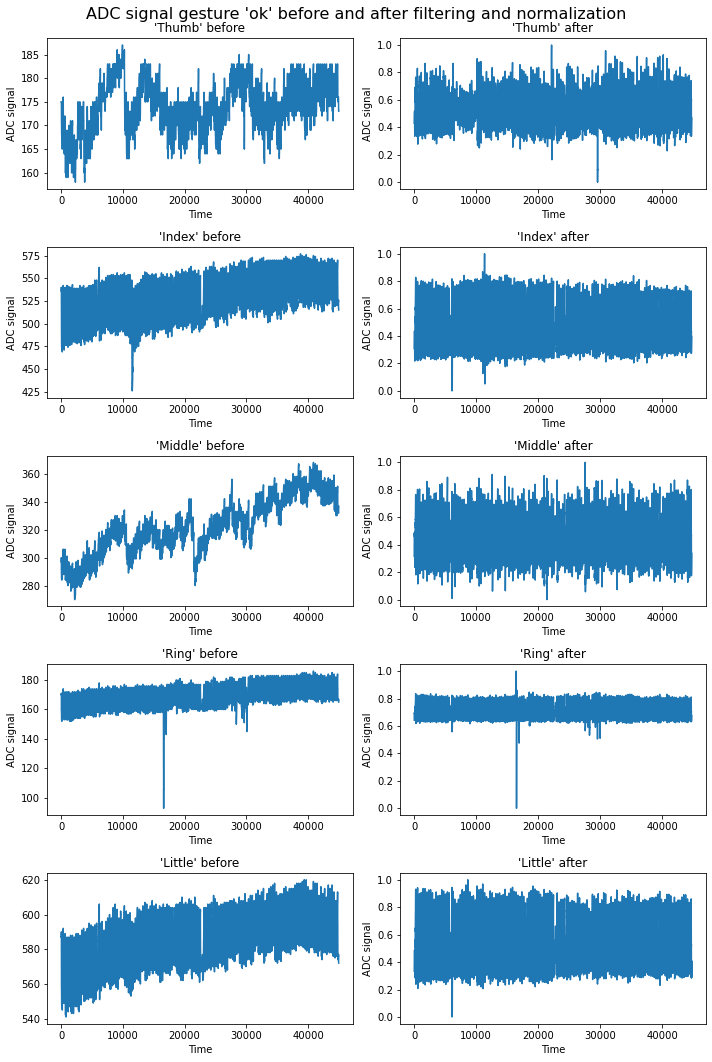

In [102]:
GR.prepared_data_visualization()

In [24]:
features = ['Thumb',
            'Ring',
            'Little',
            'Middle',
            'Index',
           ]

target = ['gesture']

In [25]:
enc = MinMaxScaler()
for feature in features:
    data_2[feature]=pd.DataFrame(enc.fit_transform(data_2[[feature]]), columns=[feature])

In [26]:
data_2.to_csv('data_for_optimization.csv') 

In [15]:
X=data_2[features].values
y=data_2[target].values

In [21]:
n=10

fit_metrics_all={}

fit_metrics={
    'Model':     [],
    'precision': [],
    'recall':    [],
    'roc_auc':        [],
    'accuracy':  []}

Classifiers ={
    'LogisticRegression': LR(),
    'Support vector machine': SVC(),
    'KNeighborsClassifier': KNC(),
    'DecisionTreeClassifier': DTC(),
    'RandomForestClassifier': RFC(),
    'CatBoostClassifier': CatBoostClassifier(),
    'XGBClassifier': XGBC(objective='binary:logistic', use_label_encoder=False),
    'LGBMClassifier': LGBMClassifier()
    }

for i in Classifiers:
    precision= []
    recall=    []
    roc_auc=        []
    accuracy=  []
    model = Classifiers[i]
    
    for j in range(1,n):
        X_train, X_test, y_train, y_test = train_test_split(X, y,  test_size=0.2)
        model.fit(X_train, np.ravel(y_train))
        y_pred=model.predict(X_test)
        
        precision.append(round(precision_score(y_test, y_pred),4))
        recall.append(round(recall_score(y_test, y_pred),4))
        roc_auc.append(round(roc_auc_score(y_test, y_pred),4))
        accuracy.append(round(accuracy_score(y_test, y_pred),4))

        
    fit_metrics_all[i]={
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc,
        'accuracy':accuracy
    }
        
    fit_metrics['Model'].append(i)
    
    fit_metrics['precision'].append(round(mean(precision),4))
    fit_metrics['recall'].append(round(mean(recall),4))
    fit_metrics['roc_auc'].append(round(mean(roc_auc),4))
    fit_metrics['accuracy'].append(round(mean(accuracy),4))


pd.DataFrame(fit_metrics).head(10)

Learning rate set to 0.047491
0:	learn: 0.6484425	total: 6.16ms	remaining: 6.15s
1:	learn: 0.6161392	total: 12.1ms	remaining: 6.04s
2:	learn: 0.5850657	total: 17.5ms	remaining: 5.8s
3:	learn: 0.5546487	total: 22.8ms	remaining: 5.68s
4:	learn: 0.5271317	total: 28.1ms	remaining: 5.6s
5:	learn: 0.5067797	total: 33.6ms	remaining: 5.56s
6:	learn: 0.4871306	total: 39.5ms	remaining: 5.61s
7:	learn: 0.4716542	total: 45.1ms	remaining: 5.59s
8:	learn: 0.4584993	total: 50.8ms	remaining: 5.59s
9:	learn: 0.4447180	total: 56.3ms	remaining: 5.58s
10:	learn: 0.4330352	total: 61.7ms	remaining: 5.55s
11:	learn: 0.4209543	total: 67.3ms	remaining: 5.54s
12:	learn: 0.4096524	total: 72.8ms	remaining: 5.53s
13:	learn: 0.4027744	total: 78.5ms	remaining: 5.53s
14:	learn: 0.3947967	total: 84.2ms	remaining: 5.53s
15:	learn: 0.3887805	total: 89.5ms	remaining: 5.51s
16:	learn: 0.3821589	total: 95.2ms	remaining: 5.5s
17:	learn: 0.3756178	total: 101ms	remaining: 5.5s
18:	learn: 0.3700399	total: 107ms	remaining: 5.5s

171:	learn: 0.2580765	total: 1.42s	remaining: 6.86s
172:	learn: 0.2579332	total: 1.43s	remaining: 6.86s
173:	learn: 0.2577988	total: 1.44s	remaining: 6.85s
174:	learn: 0.2576593	total: 1.45s	remaining: 6.84s
175:	learn: 0.2575483	total: 1.46s	remaining: 6.82s
176:	learn: 0.2571278	total: 1.46s	remaining: 6.8s
177:	learn: 0.2568881	total: 1.47s	remaining: 6.79s
178:	learn: 0.2566301	total: 1.48s	remaining: 6.77s
179:	learn: 0.2564959	total: 1.48s	remaining: 6.76s
180:	learn: 0.2563107	total: 1.49s	remaining: 6.74s
181:	learn: 0.2561517	total: 1.5s	remaining: 6.72s
182:	learn: 0.2560453	total: 1.5s	remaining: 6.71s
183:	learn: 0.2558155	total: 1.51s	remaining: 6.69s
184:	learn: 0.2556651	total: 1.51s	remaining: 6.68s
185:	learn: 0.2554916	total: 1.52s	remaining: 6.66s
186:	learn: 0.2552819	total: 1.53s	remaining: 6.65s
187:	learn: 0.2551106	total: 1.54s	remaining: 6.65s
188:	learn: 0.2547992	total: 1.55s	remaining: 6.64s
189:	learn: 0.2546256	total: 1.55s	remaining: 6.63s
190:	learn: 0.2

356:	learn: 0.2263830	total: 2.81s	remaining: 5.06s
357:	learn: 0.2262814	total: 2.82s	remaining: 5.05s
358:	learn: 0.2261841	total: 2.83s	remaining: 5.05s
359:	learn: 0.2260195	total: 2.83s	remaining: 5.04s
360:	learn: 0.2259411	total: 2.84s	remaining: 5.03s
361:	learn: 0.2258737	total: 2.85s	remaining: 5.02s
362:	learn: 0.2257644	total: 2.85s	remaining: 5.01s
363:	learn: 0.2255970	total: 2.86s	remaining: 5s
364:	learn: 0.2254940	total: 2.87s	remaining: 4.99s
365:	learn: 0.2253887	total: 2.87s	remaining: 4.98s
366:	learn: 0.2252719	total: 2.88s	remaining: 4.97s
367:	learn: 0.2251868	total: 2.89s	remaining: 4.96s
368:	learn: 0.2250389	total: 2.89s	remaining: 4.95s
369:	learn: 0.2249228	total: 2.9s	remaining: 4.94s
370:	learn: 0.2248618	total: 2.91s	remaining: 4.93s
371:	learn: 0.2247263	total: 2.91s	remaining: 4.92s
372:	learn: 0.2246065	total: 2.92s	remaining: 4.91s
373:	learn: 0.2243769	total: 2.92s	remaining: 4.9s
374:	learn: 0.2242675	total: 2.93s	remaining: 4.89s
375:	learn: 0.224

528:	learn: 0.2049521	total: 3.99s	remaining: 3.55s
529:	learn: 0.2048766	total: 4s	remaining: 3.55s
530:	learn: 0.2047688	total: 4.01s	remaining: 3.54s
531:	learn: 0.2047035	total: 4.02s	remaining: 3.53s
532:	learn: 0.2046099	total: 4.02s	remaining: 3.52s
533:	learn: 0.2045221	total: 4.03s	remaining: 3.52s
534:	learn: 0.2044411	total: 4.04s	remaining: 3.51s
535:	learn: 0.2043801	total: 4.04s	remaining: 3.5s
536:	learn: 0.2042167	total: 4.05s	remaining: 3.49s
537:	learn: 0.2041356	total: 4.06s	remaining: 3.48s
538:	learn: 0.2040228	total: 4.07s	remaining: 3.48s
539:	learn: 0.2039252	total: 4.07s	remaining: 3.47s
540:	learn: 0.2037873	total: 4.08s	remaining: 3.46s
541:	learn: 0.2036741	total: 4.08s	remaining: 3.45s
542:	learn: 0.2035915	total: 4.09s	remaining: 3.44s
543:	learn: 0.2034239	total: 4.1s	remaining: 3.43s
544:	learn: 0.2032935	total: 4.1s	remaining: 3.43s
545:	learn: 0.2032118	total: 4.11s	remaining: 3.42s
546:	learn: 0.2030599	total: 4.12s	remaining: 3.41s
547:	learn: 0.2029

705:	learn: 0.1882380	total: 5.17s	remaining: 2.15s
706:	learn: 0.1881857	total: 5.18s	remaining: 2.15s
707:	learn: 0.1881393	total: 5.19s	remaining: 2.14s
708:	learn: 0.1880647	total: 5.2s	remaining: 2.13s
709:	learn: 0.1879554	total: 5.2s	remaining: 2.13s
710:	learn: 0.1878874	total: 5.21s	remaining: 2.12s
711:	learn: 0.1878249	total: 5.22s	remaining: 2.11s
712:	learn: 0.1876966	total: 5.22s	remaining: 2.1s
713:	learn: 0.1875731	total: 5.23s	remaining: 2.09s
714:	learn: 0.1874706	total: 5.24s	remaining: 2.09s
715:	learn: 0.1873726	total: 5.24s	remaining: 2.08s
716:	learn: 0.1873131	total: 5.25s	remaining: 2.07s
717:	learn: 0.1872131	total: 5.25s	remaining: 2.06s
718:	learn: 0.1871532	total: 5.26s	remaining: 2.06s
719:	learn: 0.1870769	total: 5.27s	remaining: 2.05s
720:	learn: 0.1869725	total: 5.27s	remaining: 2.04s
721:	learn: 0.1869190	total: 5.28s	remaining: 2.03s
722:	learn: 0.1868369	total: 5.29s	remaining: 2.02s
723:	learn: 0.1867244	total: 5.29s	remaining: 2.02s
724:	learn: 0.1

880:	learn: 0.1751123	total: 6.36s	remaining: 859ms
881:	learn: 0.1750599	total: 6.37s	remaining: 853ms
882:	learn: 0.1750195	total: 6.38s	remaining: 845ms
883:	learn: 0.1749594	total: 6.39s	remaining: 838ms
884:	learn: 0.1748854	total: 6.39s	remaining: 831ms
885:	learn: 0.1748545	total: 6.4s	remaining: 824ms
886:	learn: 0.1748075	total: 6.41s	remaining: 816ms
887:	learn: 0.1747631	total: 6.41s	remaining: 809ms
888:	learn: 0.1747104	total: 6.42s	remaining: 802ms
889:	learn: 0.1746169	total: 6.42s	remaining: 794ms
890:	learn: 0.1745890	total: 6.43s	remaining: 787ms
891:	learn: 0.1745232	total: 6.44s	remaining: 780ms
892:	learn: 0.1744379	total: 6.44s	remaining: 772ms
893:	learn: 0.1743786	total: 6.45s	remaining: 765ms
894:	learn: 0.1743130	total: 6.46s	remaining: 758ms
895:	learn: 0.1742149	total: 6.46s	remaining: 750ms
896:	learn: 0.1741339	total: 6.47s	remaining: 743ms
897:	learn: 0.1740524	total: 6.48s	remaining: 736ms
898:	learn: 0.1739801	total: 6.48s	remaining: 728ms
899:	learn: 0

59:	learn: 0.2967330	total: 388ms	remaining: 6.07s
60:	learn: 0.2961809	total: 396ms	remaining: 6.09s
61:	learn: 0.2957996	total: 406ms	remaining: 6.14s
62:	learn: 0.2949498	total: 413ms	remaining: 6.14s
63:	learn: 0.2939986	total: 420ms	remaining: 6.14s
64:	learn: 0.2934615	total: 426ms	remaining: 6.13s
65:	learn: 0.2927466	total: 433ms	remaining: 6.13s
66:	learn: 0.2922621	total: 439ms	remaining: 6.12s
67:	learn: 0.2916046	total: 446ms	remaining: 6.11s
68:	learn: 0.2907800	total: 452ms	remaining: 6.1s
69:	learn: 0.2903763	total: 459ms	remaining: 6.09s
70:	learn: 0.2900407	total: 465ms	remaining: 6.08s
71:	learn: 0.2895408	total: 471ms	remaining: 6.07s
72:	learn: 0.2892239	total: 477ms	remaining: 6.06s
73:	learn: 0.2887411	total: 483ms	remaining: 6.05s
74:	learn: 0.2882424	total: 490ms	remaining: 6.04s
75:	learn: 0.2874523	total: 497ms	remaining: 6.04s
76:	learn: 0.2869718	total: 503ms	remaining: 6.03s
77:	learn: 0.2864886	total: 509ms	remaining: 6.02s
78:	learn: 0.2861276	total: 515m

231:	learn: 0.2453437	total: 1.58s	remaining: 5.25s
232:	learn: 0.2452181	total: 1.59s	remaining: 5.25s
233:	learn: 0.2451047	total: 1.6s	remaining: 5.24s
234:	learn: 0.2449730	total: 1.61s	remaining: 5.25s
235:	learn: 0.2448358	total: 1.62s	remaining: 5.24s
236:	learn: 0.2447185	total: 1.63s	remaining: 5.23s
237:	learn: 0.2445681	total: 1.63s	remaining: 5.23s
238:	learn: 0.2442260	total: 1.64s	remaining: 5.22s
239:	learn: 0.2440432	total: 1.65s	remaining: 5.21s
240:	learn: 0.2439178	total: 1.65s	remaining: 5.2s
241:	learn: 0.2436671	total: 1.66s	remaining: 5.2s
242:	learn: 0.2435307	total: 1.66s	remaining: 5.19s
243:	learn: 0.2434074	total: 1.67s	remaining: 5.18s
244:	learn: 0.2431636	total: 1.68s	remaining: 5.17s
245:	learn: 0.2430884	total: 1.68s	remaining: 5.16s
246:	learn: 0.2428978	total: 1.69s	remaining: 5.15s
247:	learn: 0.2427608	total: 1.7s	remaining: 5.14s
248:	learn: 0.2426520	total: 1.7s	remaining: 5.14s
249:	learn: 0.2425687	total: 1.71s	remaining: 5.13s
250:	learn: 0.242

397:	learn: 0.2212517	total: 2.73s	remaining: 4.13s
398:	learn: 0.2210950	total: 2.74s	remaining: 4.13s
399:	learn: 0.2210450	total: 2.75s	remaining: 4.12s
400:	learn: 0.2209330	total: 2.76s	remaining: 4.12s
401:	learn: 0.2207709	total: 2.76s	remaining: 4.11s
402:	learn: 0.2206031	total: 2.77s	remaining: 4.1s
403:	learn: 0.2204948	total: 2.78s	remaining: 4.1s
404:	learn: 0.2203197	total: 2.78s	remaining: 4.09s
405:	learn: 0.2201701	total: 2.79s	remaining: 4.08s
406:	learn: 0.2200307	total: 2.8s	remaining: 4.07s
407:	learn: 0.2199411	total: 2.8s	remaining: 4.07s
408:	learn: 0.2197876	total: 2.81s	remaining: 4.06s
409:	learn: 0.2196805	total: 2.81s	remaining: 4.05s
410:	learn: 0.2196028	total: 2.82s	remaining: 4.04s
411:	learn: 0.2194041	total: 2.83s	remaining: 4.04s
412:	learn: 0.2191543	total: 2.83s	remaining: 4.03s
413:	learn: 0.2191132	total: 2.84s	remaining: 4.02s
414:	learn: 0.2188690	total: 2.85s	remaining: 4.01s
415:	learn: 0.2187654	total: 2.85s	remaining: 4.01s
416:	learn: 0.21

565:	learn: 0.2018075	total: 3.92s	remaining: 3s
566:	learn: 0.2017122	total: 3.93s	remaining: 3s
567:	learn: 0.2016328	total: 3.94s	remaining: 3s
568:	learn: 0.2015495	total: 3.95s	remaining: 2.99s
569:	learn: 0.2014775	total: 3.95s	remaining: 2.98s
570:	learn: 0.2013915	total: 3.96s	remaining: 2.98s
571:	learn: 0.2013273	total: 3.97s	remaining: 2.97s
572:	learn: 0.2011656	total: 3.98s	remaining: 2.96s
573:	learn: 0.2010294	total: 3.98s	remaining: 2.96s
574:	learn: 0.2009626	total: 3.99s	remaining: 2.95s
575:	learn: 0.2008385	total: 4s	remaining: 2.94s
576:	learn: 0.2007521	total: 4s	remaining: 2.93s
577:	learn: 0.2006980	total: 4.01s	remaining: 2.93s
578:	learn: 0.2006044	total: 4.02s	remaining: 2.92s
579:	learn: 0.2004560	total: 4.03s	remaining: 2.92s
580:	learn: 0.2002881	total: 4.03s	remaining: 2.91s
581:	learn: 0.2002098	total: 4.04s	remaining: 2.9s
582:	learn: 0.2001005	total: 4.05s	remaining: 2.89s
583:	learn: 0.1999912	total: 4.05s	remaining: 2.89s
584:	learn: 0.1998905	total:

736:	learn: 0.1864348	total: 5.1s	remaining: 1.82s
737:	learn: 0.1863801	total: 5.11s	remaining: 1.81s
738:	learn: 0.1862284	total: 5.12s	remaining: 1.81s
739:	learn: 0.1861275	total: 5.12s	remaining: 1.8s
740:	learn: 0.1860227	total: 5.13s	remaining: 1.79s
741:	learn: 0.1859597	total: 5.14s	remaining: 1.79s
742:	learn: 0.1858437	total: 5.14s	remaining: 1.78s
743:	learn: 0.1857207	total: 5.15s	remaining: 1.77s
744:	learn: 0.1856377	total: 5.16s	remaining: 1.76s
745:	learn: 0.1855527	total: 5.16s	remaining: 1.76s
746:	learn: 0.1854939	total: 5.17s	remaining: 1.75s
747:	learn: 0.1853811	total: 5.18s	remaining: 1.74s
748:	learn: 0.1853341	total: 5.18s	remaining: 1.74s
749:	learn: 0.1852707	total: 5.19s	remaining: 1.73s
750:	learn: 0.1852109	total: 5.2s	remaining: 1.72s
751:	learn: 0.1851706	total: 5.2s	remaining: 1.72s
752:	learn: 0.1851005	total: 5.21s	remaining: 1.71s
753:	learn: 0.1849858	total: 5.21s	remaining: 1.7s
754:	learn: 0.1848873	total: 5.22s	remaining: 1.69s
755:	learn: 0.184

908:	learn: 0.1736347	total: 6.45s	remaining: 646ms
909:	learn: 0.1735720	total: 6.46s	remaining: 639ms
910:	learn: 0.1734777	total: 6.47s	remaining: 632ms
911:	learn: 0.1733716	total: 6.47s	remaining: 625ms
912:	learn: 0.1733002	total: 6.48s	remaining: 618ms
913:	learn: 0.1732465	total: 6.49s	remaining: 610ms
914:	learn: 0.1731781	total: 6.49s	remaining: 603ms
915:	learn: 0.1731036	total: 6.5s	remaining: 596ms
916:	learn: 0.1730098	total: 6.51s	remaining: 589ms
917:	learn: 0.1728996	total: 6.51s	remaining: 582ms
918:	learn: 0.1728110	total: 6.52s	remaining: 575ms
919:	learn: 0.1727436	total: 6.53s	remaining: 568ms
920:	learn: 0.1726418	total: 6.54s	remaining: 561ms
921:	learn: 0.1725715	total: 6.54s	remaining: 554ms
922:	learn: 0.1724566	total: 6.55s	remaining: 547ms
923:	learn: 0.1723973	total: 6.56s	remaining: 539ms
924:	learn: 0.1723284	total: 6.57s	remaining: 532ms
925:	learn: 0.1722430	total: 6.57s	remaining: 525ms
926:	learn: 0.1721956	total: 6.58s	remaining: 518ms
927:	learn: 0

78:	learn: 0.2867866	total: 595ms	remaining: 6.94s
79:	learn: 0.2862766	total: 603ms	remaining: 6.93s
80:	learn: 0.2859104	total: 613ms	remaining: 6.95s
81:	learn: 0.2854492	total: 625ms	remaining: 7s
82:	learn: 0.2846606	total: 632ms	remaining: 6.99s
83:	learn: 0.2842306	total: 640ms	remaining: 6.98s
84:	learn: 0.2837695	total: 647ms	remaining: 6.97s
85:	learn: 0.2833322	total: 655ms	remaining: 6.96s
86:	learn: 0.2827532	total: 663ms	remaining: 6.96s
87:	learn: 0.2822907	total: 673ms	remaining: 6.97s
88:	learn: 0.2819439	total: 680ms	remaining: 6.96s
89:	learn: 0.2814500	total: 690ms	remaining: 6.98s
90:	learn: 0.2809670	total: 698ms	remaining: 6.97s
91:	learn: 0.2804043	total: 709ms	remaining: 7s
92:	learn: 0.2801354	total: 718ms	remaining: 7s
93:	learn: 0.2798308	total: 726ms	remaining: 6.99s
94:	learn: 0.2796625	total: 734ms	remaining: 7s
95:	learn: 0.2792695	total: 742ms	remaining: 6.99s
96:	learn: 0.2790381	total: 753ms	remaining: 7.01s
97:	learn: 0.2787517	total: 760ms	remaining

253:	learn: 0.2431589	total: 2.17s	remaining: 6.39s
254:	learn: 0.2429228	total: 2.19s	remaining: 6.39s
255:	learn: 0.2427190	total: 2.2s	remaining: 6.39s
256:	learn: 0.2424067	total: 2.21s	remaining: 6.38s
257:	learn: 0.2422206	total: 2.22s	remaining: 6.38s
258:	learn: 0.2420079	total: 2.23s	remaining: 6.37s
259:	learn: 0.2418805	total: 2.24s	remaining: 6.37s
260:	learn: 0.2418152	total: 2.25s	remaining: 6.36s
261:	learn: 0.2415624	total: 2.25s	remaining: 6.35s
262:	learn: 0.2414396	total: 2.26s	remaining: 6.34s
263:	learn: 0.2412385	total: 2.27s	remaining: 6.33s
264:	learn: 0.2411495	total: 2.28s	remaining: 6.32s
265:	learn: 0.2409140	total: 2.29s	remaining: 6.31s
266:	learn: 0.2407400	total: 2.3s	remaining: 6.3s
267:	learn: 0.2405401	total: 2.3s	remaining: 6.29s
268:	learn: 0.2403883	total: 2.31s	remaining: 6.29s
269:	learn: 0.2401776	total: 2.32s	remaining: 6.28s
270:	learn: 0.2400483	total: 2.33s	remaining: 6.27s
271:	learn: 0.2399146	total: 2.34s	remaining: 6.26s
272:	learn: 0.23

426:	learn: 0.2186412	total: 3.77s	remaining: 5.06s
427:	learn: 0.2185073	total: 3.78s	remaining: 5.05s
428:	learn: 0.2183332	total: 3.79s	remaining: 5.04s
429:	learn: 0.2181847	total: 3.8s	remaining: 5.04s
430:	learn: 0.2179469	total: 3.81s	remaining: 5.03s
431:	learn: 0.2177982	total: 3.82s	remaining: 5.02s
432:	learn: 0.2175582	total: 3.83s	remaining: 5.01s
433:	learn: 0.2174262	total: 3.84s	remaining: 5s
434:	learn: 0.2173385	total: 3.85s	remaining: 5s
435:	learn: 0.2172787	total: 3.86s	remaining: 4.99s
436:	learn: 0.2171513	total: 3.86s	remaining: 4.98s
437:	learn: 0.2170602	total: 3.87s	remaining: 4.97s
438:	learn: 0.2170084	total: 3.88s	remaining: 4.96s
439:	learn: 0.2167711	total: 3.89s	remaining: 4.95s
440:	learn: 0.2166705	total: 3.9s	remaining: 4.95s
441:	learn: 0.2165622	total: 3.91s	remaining: 4.93s
442:	learn: 0.2164268	total: 3.92s	remaining: 4.93s
443:	learn: 0.2163803	total: 3.92s	remaining: 4.92s
444:	learn: 0.2162287	total: 3.94s	remaining: 4.91s
445:	learn: 0.216055

595:	learn: 0.1993775	total: 5.36s	remaining: 3.63s
596:	learn: 0.1993350	total: 5.37s	remaining: 3.62s
597:	learn: 0.1992300	total: 5.38s	remaining: 3.62s
598:	learn: 0.1991709	total: 5.39s	remaining: 3.61s
599:	learn: 0.1990814	total: 5.39s	remaining: 3.6s
600:	learn: 0.1990061	total: 5.4s	remaining: 3.59s
601:	learn: 0.1989413	total: 5.41s	remaining: 3.58s
602:	learn: 0.1988661	total: 5.42s	remaining: 3.57s
603:	learn: 0.1987730	total: 5.43s	remaining: 3.56s
604:	learn: 0.1987053	total: 5.44s	remaining: 3.55s
605:	learn: 0.1986390	total: 5.45s	remaining: 3.54s
606:	learn: 0.1985201	total: 5.46s	remaining: 3.53s
607:	learn: 0.1983886	total: 5.46s	remaining: 3.52s
608:	learn: 0.1982863	total: 5.47s	remaining: 3.52s
609:	learn: 0.1982032	total: 5.48s	remaining: 3.5s
610:	learn: 0.1981079	total: 5.49s	remaining: 3.5s
611:	learn: 0.1980165	total: 5.5s	remaining: 3.49s
612:	learn: 0.1979489	total: 5.51s	remaining: 3.48s
613:	learn: 0.1978798	total: 5.52s	remaining: 3.47s
614:	learn: 0.197

756:	learn: 0.1859835	total: 6.77s	remaining: 2.17s
757:	learn: 0.1858431	total: 6.78s	remaining: 2.17s
758:	learn: 0.1857196	total: 6.79s	remaining: 2.16s
759:	learn: 0.1855940	total: 6.8s	remaining: 2.15s
760:	learn: 0.1854677	total: 6.81s	remaining: 2.14s
761:	learn: 0.1854023	total: 6.82s	remaining: 2.13s
762:	learn: 0.1852304	total: 6.83s	remaining: 2.12s
763:	learn: 0.1851319	total: 6.84s	remaining: 2.11s
764:	learn: 0.1850245	total: 6.85s	remaining: 2.1s
765:	learn: 0.1849870	total: 6.86s	remaining: 2.1s
766:	learn: 0.1849308	total: 6.87s	remaining: 2.09s
767:	learn: 0.1849086	total: 6.88s	remaining: 2.08s
768:	learn: 0.1848257	total: 6.89s	remaining: 2.07s
769:	learn: 0.1847570	total: 6.9s	remaining: 2.06s
770:	learn: 0.1846633	total: 6.91s	remaining: 2.05s
771:	learn: 0.1845912	total: 6.92s	remaining: 2.04s
772:	learn: 0.1844876	total: 6.92s	remaining: 2.03s
773:	learn: 0.1843583	total: 6.93s	remaining: 2.02s
774:	learn: 0.1842252	total: 6.94s	remaining: 2.02s
775:	learn: 0.18

928:	learn: 0.1723343	total: 8.33s	remaining: 637ms
929:	learn: 0.1723134	total: 8.34s	remaining: 628ms
930:	learn: 0.1722334	total: 8.35s	remaining: 619ms
931:	learn: 0.1721822	total: 8.36s	remaining: 610ms
932:	learn: 0.1720913	total: 8.37s	remaining: 601ms
933:	learn: 0.1720077	total: 8.38s	remaining: 592ms
934:	learn: 0.1719269	total: 8.39s	remaining: 583ms
935:	learn: 0.1718373	total: 8.4s	remaining: 574ms
936:	learn: 0.1717490	total: 8.4s	remaining: 565ms
937:	learn: 0.1716981	total: 8.41s	remaining: 556ms
938:	learn: 0.1716633	total: 8.42s	remaining: 547ms
939:	learn: 0.1716263	total: 8.43s	remaining: 538ms
940:	learn: 0.1715184	total: 8.44s	remaining: 529ms
941:	learn: 0.1714506	total: 8.45s	remaining: 520ms
942:	learn: 0.1713476	total: 8.45s	remaining: 511ms
943:	learn: 0.1712776	total: 8.46s	remaining: 502ms
944:	learn: 0.1711950	total: 8.47s	remaining: 493ms
945:	learn: 0.1711334	total: 8.48s	remaining: 484ms
946:	learn: 0.1710526	total: 8.49s	remaining: 475ms
947:	learn: 0.

91:	learn: 0.2812704	total: 789ms	remaining: 7.79s
92:	learn: 0.2809902	total: 803ms	remaining: 7.83s
93:	learn: 0.2807003	total: 814ms	remaining: 7.85s
94:	learn: 0.2804560	total: 822ms	remaining: 7.83s
95:	learn: 0.2797864	total: 830ms	remaining: 7.81s
96:	learn: 0.2792006	total: 838ms	remaining: 7.8s
97:	learn: 0.2789312	total: 847ms	remaining: 7.8s
98:	learn: 0.2785371	total: 857ms	remaining: 7.8s
99:	learn: 0.2782197	total: 865ms	remaining: 7.79s
100:	learn: 0.2777026	total: 873ms	remaining: 7.77s
101:	learn: 0.2772619	total: 880ms	remaining: 7.75s
102:	learn: 0.2769520	total: 888ms	remaining: 7.73s
103:	learn: 0.2767153	total: 898ms	remaining: 7.74s
104:	learn: 0.2765093	total: 909ms	remaining: 7.75s
105:	learn: 0.2761889	total: 918ms	remaining: 7.75s
106:	learn: 0.2759985	total: 929ms	remaining: 7.75s
107:	learn: 0.2757016	total: 947ms	remaining: 7.82s
108:	learn: 0.2753377	total: 971ms	remaining: 7.94s
109:	learn: 0.2749948	total: 988ms	remaining: 7.99s
110:	learn: 0.2747494	to

251:	learn: 0.2438494	total: 2.61s	remaining: 7.74s
252:	learn: 0.2435302	total: 2.63s	remaining: 7.76s
253:	learn: 0.2434275	total: 2.65s	remaining: 7.77s
254:	learn: 0.2432803	total: 2.67s	remaining: 7.79s
255:	learn: 0.2431219	total: 2.69s	remaining: 7.81s
256:	learn: 0.2430491	total: 2.7s	remaining: 7.82s
257:	learn: 0.2428720	total: 2.73s	remaining: 7.86s
258:	learn: 0.2426285	total: 2.75s	remaining: 7.88s
259:	learn: 0.2424580	total: 2.77s	remaining: 7.9s
260:	learn: 0.2422517	total: 2.79s	remaining: 7.91s
261:	learn: 0.2419171	total: 2.81s	remaining: 7.93s
262:	learn: 0.2416638	total: 2.84s	remaining: 7.96s
263:	learn: 0.2415431	total: 2.86s	remaining: 7.98s
264:	learn: 0.2412469	total: 2.88s	remaining: 7.99s
265:	learn: 0.2411874	total: 2.9s	remaining: 8.01s
266:	learn: 0.2409269	total: 2.92s	remaining: 8.01s
267:	learn: 0.2407446	total: 2.94s	remaining: 8.02s
268:	learn: 0.2406296	total: 2.95s	remaining: 8.02s
269:	learn: 0.2404465	total: 2.96s	remaining: 8.01s
270:	learn: 0.2

418:	learn: 0.2190923	total: 4.21s	remaining: 5.84s
419:	learn: 0.2188874	total: 4.22s	remaining: 5.83s
420:	learn: 0.2187551	total: 4.24s	remaining: 5.83s
421:	learn: 0.2186702	total: 4.26s	remaining: 5.83s
422:	learn: 0.2184925	total: 4.27s	remaining: 5.82s
423:	learn: 0.2183403	total: 4.28s	remaining: 5.81s
424:	learn: 0.2182224	total: 4.29s	remaining: 5.8s
425:	learn: 0.2180367	total: 4.3s	remaining: 5.79s
426:	learn: 0.2179936	total: 4.3s	remaining: 5.78s
427:	learn: 0.2178556	total: 4.31s	remaining: 5.76s
428:	learn: 0.2177606	total: 4.32s	remaining: 5.75s
429:	learn: 0.2176272	total: 4.33s	remaining: 5.74s
430:	learn: 0.2175251	total: 4.34s	remaining: 5.73s
431:	learn: 0.2174565	total: 4.35s	remaining: 5.72s
432:	learn: 0.2172937	total: 4.36s	remaining: 5.7s
433:	learn: 0.2171460	total: 4.36s	remaining: 5.69s
434:	learn: 0.2169793	total: 4.37s	remaining: 5.68s
435:	learn: 0.2168029	total: 4.38s	remaining: 5.67s
436:	learn: 0.2167121	total: 4.39s	remaining: 5.66s
437:	learn: 0.21

592:	learn: 0.1989480	total: 5.79s	remaining: 3.98s
593:	learn: 0.1988067	total: 5.8s	remaining: 3.96s
594:	learn: 0.1986860	total: 5.81s	remaining: 3.95s
595:	learn: 0.1985563	total: 5.82s	remaining: 3.95s
596:	learn: 0.1985075	total: 5.83s	remaining: 3.94s
597:	learn: 0.1983783	total: 5.84s	remaining: 3.93s
598:	learn: 0.1982626	total: 5.85s	remaining: 3.92s
599:	learn: 0.1981325	total: 5.86s	remaining: 3.91s
600:	learn: 0.1980191	total: 5.87s	remaining: 3.9s
601:	learn: 0.1978706	total: 5.88s	remaining: 3.89s
602:	learn: 0.1977737	total: 5.89s	remaining: 3.88s
603:	learn: 0.1976632	total: 5.9s	remaining: 3.87s
604:	learn: 0.1975015	total: 5.91s	remaining: 3.86s
605:	learn: 0.1973500	total: 5.92s	remaining: 3.85s
606:	learn: 0.1972837	total: 5.92s	remaining: 3.83s
607:	learn: 0.1971422	total: 5.93s	remaining: 3.82s
608:	learn: 0.1970503	total: 5.94s	remaining: 3.81s
609:	learn: 0.1969548	total: 5.95s	remaining: 3.8s
610:	learn: 0.1968778	total: 5.95s	remaining: 3.79s
611:	learn: 0.19

767:	learn: 0.1836117	total: 7.36s	remaining: 2.22s
768:	learn: 0.1835808	total: 7.38s	remaining: 2.22s
769:	learn: 0.1835543	total: 7.39s	remaining: 2.21s
770:	learn: 0.1835093	total: 7.4s	remaining: 2.2s
771:	learn: 0.1833993	total: 7.41s	remaining: 2.19s
772:	learn: 0.1833412	total: 7.43s	remaining: 2.18s
773:	learn: 0.1832572	total: 7.44s	remaining: 2.17s
774:	learn: 0.1831684	total: 7.45s	remaining: 2.16s
775:	learn: 0.1830693	total: 7.46s	remaining: 2.15s
776:	learn: 0.1830063	total: 7.47s	remaining: 2.14s
777:	learn: 0.1829388	total: 7.48s	remaining: 2.13s
778:	learn: 0.1828543	total: 7.49s	remaining: 2.12s
779:	learn: 0.1827624	total: 7.5s	remaining: 2.11s
780:	learn: 0.1826538	total: 7.51s	remaining: 2.1s
781:	learn: 0.1825977	total: 7.52s	remaining: 2.1s
782:	learn: 0.1825706	total: 7.53s	remaining: 2.08s
783:	learn: 0.1825430	total: 7.54s	remaining: 2.08s
784:	learn: 0.1824923	total: 7.55s	remaining: 2.07s
785:	learn: 0.1824245	total: 7.55s	remaining: 2.06s
786:	learn: 0.182

944:	learn: 0.1707616	total: 8.97s	remaining: 522ms
945:	learn: 0.1707081	total: 8.99s	remaining: 513ms
946:	learn: 0.1706223	total: 9s	remaining: 504ms
947:	learn: 0.1705037	total: 9.01s	remaining: 494ms
948:	learn: 0.1704519	total: 9.02s	remaining: 485ms
949:	learn: 0.1703513	total: 9.03s	remaining: 475ms
950:	learn: 0.1702816	total: 9.04s	remaining: 466ms
951:	learn: 0.1702287	total: 9.04s	remaining: 456ms
952:	learn: 0.1701915	total: 9.05s	remaining: 446ms
953:	learn: 0.1701521	total: 9.06s	remaining: 437ms
954:	learn: 0.1701150	total: 9.07s	remaining: 427ms
955:	learn: 0.1700643	total: 9.08s	remaining: 418ms
956:	learn: 0.1699800	total: 9.09s	remaining: 408ms
957:	learn: 0.1698993	total: 9.09s	remaining: 399ms
958:	learn: 0.1698505	total: 9.1s	remaining: 389ms
959:	learn: 0.1698092	total: 9.11s	remaining: 379ms
960:	learn: 0.1697535	total: 9.11s	remaining: 370ms
961:	learn: 0.1697007	total: 9.12s	remaining: 360ms
962:	learn: 0.1696346	total: 9.13s	remaining: 351ms
963:	learn: 0.16

110:	learn: 0.2732027	total: 981ms	remaining: 7.85s
111:	learn: 0.2728399	total: 988ms	remaining: 7.83s
112:	learn: 0.2725833	total: 1s	remaining: 7.87s
113:	learn: 0.2723201	total: 1.01s	remaining: 7.88s
114:	learn: 0.2719155	total: 1.02s	remaining: 7.89s
115:	learn: 0.2717428	total: 1.03s	remaining: 7.86s
116:	learn: 0.2712337	total: 1.04s	remaining: 7.86s
117:	learn: 0.2710049	total: 1.05s	remaining: 7.83s
118:	learn: 0.2707719	total: 1.06s	remaining: 7.83s
119:	learn: 0.2705575	total: 1.06s	remaining: 7.81s
120:	learn: 0.2702765	total: 1.07s	remaining: 7.8s
121:	learn: 0.2697330	total: 1.08s	remaining: 7.78s
122:	learn: 0.2693984	total: 1.09s	remaining: 7.78s
123:	learn: 0.2688595	total: 1.1s	remaining: 7.75s
124:	learn: 0.2685622	total: 1.11s	remaining: 7.75s
125:	learn: 0.2681565	total: 1.11s	remaining: 7.73s
126:	learn: 0.2679158	total: 1.12s	remaining: 7.72s
127:	learn: 0.2677297	total: 1.13s	remaining: 7.7s
128:	learn: 0.2675378	total: 1.14s	remaining: 7.7s
129:	learn: 0.26734

292:	learn: 0.2361218	total: 2.37s	remaining: 5.73s
293:	learn: 0.2357930	total: 2.38s	remaining: 5.72s
294:	learn: 0.2356779	total: 2.39s	remaining: 5.71s
295:	learn: 0.2354514	total: 2.4s	remaining: 5.71s
296:	learn: 0.2353321	total: 2.41s	remaining: 5.7s
297:	learn: 0.2351767	total: 2.41s	remaining: 5.69s
298:	learn: 0.2349654	total: 2.42s	remaining: 5.67s
299:	learn: 0.2348395	total: 2.43s	remaining: 5.66s
300:	learn: 0.2347192	total: 2.43s	remaining: 5.65s
301:	learn: 0.2346424	total: 2.44s	remaining: 5.64s
302:	learn: 0.2345484	total: 2.45s	remaining: 5.63s
303:	learn: 0.2344261	total: 2.45s	remaining: 5.62s
304:	learn: 0.2342795	total: 2.46s	remaining: 5.61s
305:	learn: 0.2341327	total: 2.47s	remaining: 5.59s
306:	learn: 0.2339689	total: 2.47s	remaining: 5.58s
307:	learn: 0.2336699	total: 2.48s	remaining: 5.57s
308:	learn: 0.2335243	total: 2.49s	remaining: 5.56s
309:	learn: 0.2334568	total: 2.49s	remaining: 5.55s
310:	learn: 0.2333543	total: 2.5s	remaining: 5.54s
311:	learn: 0.2

460:	learn: 0.2137074	total: 3.55s	remaining: 4.16s
461:	learn: 0.2135995	total: 3.56s	remaining: 4.15s
462:	learn: 0.2134876	total: 3.59s	remaining: 4.17s
463:	learn: 0.2134323	total: 3.6s	remaining: 4.16s
464:	learn: 0.2133612	total: 3.61s	remaining: 4.16s
465:	learn: 0.2131308	total: 3.62s	remaining: 4.15s
466:	learn: 0.2129538	total: 3.63s	remaining: 4.14s
467:	learn: 0.2128201	total: 3.63s	remaining: 4.13s
468:	learn: 0.2127110	total: 3.64s	remaining: 4.12s
469:	learn: 0.2126165	total: 3.65s	remaining: 4.11s
470:	learn: 0.2125598	total: 3.65s	remaining: 4.1s
471:	learn: 0.2124706	total: 3.66s	remaining: 4.09s
472:	learn: 0.2124037	total: 3.67s	remaining: 4.08s
473:	learn: 0.2122609	total: 3.67s	remaining: 4.08s
474:	learn: 0.2121160	total: 3.68s	remaining: 4.07s
475:	learn: 0.2119368	total: 3.69s	remaining: 4.06s
476:	learn: 0.2117695	total: 3.69s	remaining: 4.05s
477:	learn: 0.2115871	total: 3.7s	remaining: 4.04s
478:	learn: 0.2114559	total: 3.71s	remaining: 4.03s
479:	learn: 0.2

624:	learn: 0.1971407	total: 4.74s	remaining: 2.84s
625:	learn: 0.1970221	total: 4.75s	remaining: 2.83s
626:	learn: 0.1969511	total: 4.76s	remaining: 2.83s
627:	learn: 0.1968322	total: 4.76s	remaining: 2.82s
628:	learn: 0.1967562	total: 4.77s	remaining: 2.81s
629:	learn: 0.1966591	total: 4.78s	remaining: 2.81s
630:	learn: 0.1965219	total: 4.79s	remaining: 2.8s
631:	learn: 0.1963825	total: 4.79s	remaining: 2.79s
632:	learn: 0.1962780	total: 4.8s	remaining: 2.78s
633:	learn: 0.1961723	total: 4.81s	remaining: 2.77s
634:	learn: 0.1960380	total: 4.81s	remaining: 2.77s
635:	learn: 0.1959146	total: 4.82s	remaining: 2.76s
636:	learn: 0.1957387	total: 4.83s	remaining: 2.75s
637:	learn: 0.1955355	total: 4.83s	remaining: 2.74s
638:	learn: 0.1954210	total: 4.84s	remaining: 2.73s
639:	learn: 0.1953173	total: 4.85s	remaining: 2.73s
640:	learn: 0.1952140	total: 4.85s	remaining: 2.72s
641:	learn: 0.1950951	total: 4.86s	remaining: 2.71s
642:	learn: 0.1949673	total: 4.87s	remaining: 2.7s
643:	learn: 0.1

791:	learn: 0.1816679	total: 5.91s	remaining: 1.55s
792:	learn: 0.1815590	total: 5.92s	remaining: 1.54s
793:	learn: 0.1814177	total: 5.93s	remaining: 1.54s
794:	learn: 0.1813419	total: 5.94s	remaining: 1.53s
795:	learn: 0.1812692	total: 5.95s	remaining: 1.52s
796:	learn: 0.1811905	total: 5.95s	remaining: 1.52s
797:	learn: 0.1811572	total: 5.96s	remaining: 1.51s
798:	learn: 0.1810942	total: 5.97s	remaining: 1.5s
799:	learn: 0.1809843	total: 5.97s	remaining: 1.49s
800:	learn: 0.1809398	total: 5.98s	remaining: 1.49s
801:	learn: 0.1808441	total: 5.99s	remaining: 1.48s
802:	learn: 0.1807017	total: 5.99s	remaining: 1.47s
803:	learn: 0.1806355	total: 6s	remaining: 1.46s
804:	learn: 0.1805792	total: 6.01s	remaining: 1.46s
805:	learn: 0.1805034	total: 6.01s	remaining: 1.45s
806:	learn: 0.1804537	total: 6.02s	remaining: 1.44s
807:	learn: 0.1803844	total: 6.03s	remaining: 1.43s
808:	learn: 0.1803079	total: 6.04s	remaining: 1.42s
809:	learn: 0.1802410	total: 6.04s	remaining: 1.42s
810:	learn: 0.18

961:	learn: 0.1695113	total: 7.11s	remaining: 281ms
962:	learn: 0.1694407	total: 7.12s	remaining: 274ms
963:	learn: 0.1693701	total: 7.13s	remaining: 266ms
964:	learn: 0.1693232	total: 7.14s	remaining: 259ms
965:	learn: 0.1692715	total: 7.15s	remaining: 252ms
966:	learn: 0.1692217	total: 7.15s	remaining: 244ms
967:	learn: 0.1691575	total: 7.16s	remaining: 237ms
968:	learn: 0.1690899	total: 7.17s	remaining: 229ms
969:	learn: 0.1689863	total: 7.17s	remaining: 222ms
970:	learn: 0.1689040	total: 7.18s	remaining: 215ms
971:	learn: 0.1688218	total: 7.19s	remaining: 207ms
972:	learn: 0.1687623	total: 7.2s	remaining: 200ms
973:	learn: 0.1686841	total: 7.2s	remaining: 192ms
974:	learn: 0.1686008	total: 7.21s	remaining: 185ms
975:	learn: 0.1685250	total: 7.22s	remaining: 177ms
976:	learn: 0.1684713	total: 7.22s	remaining: 170ms
977:	learn: 0.1684261	total: 7.23s	remaining: 163ms
978:	learn: 0.1683999	total: 7.24s	remaining: 155ms
979:	learn: 0.1683565	total: 7.24s	remaining: 148ms
980:	learn: 0.

141:	learn: 0.2634904	total: 978ms	remaining: 5.91s
142:	learn: 0.2632868	total: 988ms	remaining: 5.92s
143:	learn: 0.2627757	total: 998ms	remaining: 5.93s
144:	learn: 0.2625041	total: 1s	remaining: 5.93s
145:	learn: 0.2622285	total: 1.01s	remaining: 5.92s
146:	learn: 0.2619469	total: 1.02s	remaining: 5.92s
147:	learn: 0.2617389	total: 1.03s	remaining: 5.91s
148:	learn: 0.2613254	total: 1.03s	remaining: 5.9s
149:	learn: 0.2611410	total: 1.04s	remaining: 5.89s
150:	learn: 0.2607728	total: 1.05s	remaining: 5.88s
151:	learn: 0.2605356	total: 1.05s	remaining: 5.87s
152:	learn: 0.2604138	total: 1.06s	remaining: 5.86s
153:	learn: 0.2597940	total: 1.06s	remaining: 5.86s
154:	learn: 0.2596916	total: 1.07s	remaining: 5.85s
155:	learn: 0.2594230	total: 1.08s	remaining: 5.84s
156:	learn: 0.2591217	total: 1.09s	remaining: 5.83s
157:	learn: 0.2588339	total: 1.09s	remaining: 5.82s
158:	learn: 0.2583748	total: 1.1s	remaining: 5.81s
159:	learn: 0.2582231	total: 1.1s	remaining: 5.8s
160:	learn: 0.25814

309:	learn: 0.2328021	total: 2.16s	remaining: 4.81s
310:	learn: 0.2326403	total: 2.17s	remaining: 4.81s
311:	learn: 0.2325479	total: 2.18s	remaining: 4.81s
312:	learn: 0.2322497	total: 2.19s	remaining: 4.8s
313:	learn: 0.2321855	total: 2.19s	remaining: 4.79s
314:	learn: 0.2320268	total: 2.2s	remaining: 4.79s
315:	learn: 0.2319137	total: 2.21s	remaining: 4.78s
316:	learn: 0.2316251	total: 2.21s	remaining: 4.77s
317:	learn: 0.2315389	total: 2.22s	remaining: 4.76s
318:	learn: 0.2312493	total: 2.23s	remaining: 4.76s
319:	learn: 0.2310200	total: 2.24s	remaining: 4.76s
320:	learn: 0.2307332	total: 2.25s	remaining: 4.75s
321:	learn: 0.2306556	total: 2.25s	remaining: 4.74s
322:	learn: 0.2305017	total: 2.26s	remaining: 4.74s
323:	learn: 0.2304405	total: 2.27s	remaining: 4.73s
324:	learn: 0.2303230	total: 2.27s	remaining: 4.72s
325:	learn: 0.2301968	total: 2.28s	remaining: 4.71s
326:	learn: 0.2300162	total: 2.29s	remaining: 4.71s
327:	learn: 0.2298314	total: 2.29s	remaining: 4.7s
328:	learn: 0.2

476:	learn: 0.2104682	total: 3.35s	remaining: 3.67s
477:	learn: 0.2102653	total: 3.36s	remaining: 3.67s
478:	learn: 0.2100836	total: 3.37s	remaining: 3.67s
479:	learn: 0.2099101	total: 3.38s	remaining: 3.66s
480:	learn: 0.2098456	total: 3.39s	remaining: 3.66s
481:	learn: 0.2097991	total: 3.4s	remaining: 3.65s
482:	learn: 0.2096142	total: 3.4s	remaining: 3.64s
483:	learn: 0.2095097	total: 3.41s	remaining: 3.63s
484:	learn: 0.2094305	total: 3.42s	remaining: 3.63s
485:	learn: 0.2092819	total: 3.42s	remaining: 3.62s
486:	learn: 0.2091420	total: 3.43s	remaining: 3.61s
487:	learn: 0.2090817	total: 3.44s	remaining: 3.61s
488:	learn: 0.2089938	total: 3.44s	remaining: 3.6s
489:	learn: 0.2089416	total: 3.45s	remaining: 3.59s
490:	learn: 0.2088627	total: 3.46s	remaining: 3.58s
491:	learn: 0.2087868	total: 3.46s	remaining: 3.58s
492:	learn: 0.2086692	total: 3.47s	remaining: 3.57s
493:	learn: 0.2085268	total: 3.48s	remaining: 3.57s
494:	learn: 0.2084511	total: 3.49s	remaining: 3.56s
495:	learn: 0.2

642:	learn: 0.1937042	total: 4.54s	remaining: 2.52s
643:	learn: 0.1936401	total: 4.56s	remaining: 2.52s
644:	learn: 0.1935275	total: 4.57s	remaining: 2.51s
645:	learn: 0.1934583	total: 4.58s	remaining: 2.51s
646:	learn: 0.1933520	total: 4.59s	remaining: 2.5s
647:	learn: 0.1932507	total: 4.59s	remaining: 2.5s
648:	learn: 0.1931159	total: 4.6s	remaining: 2.49s
649:	learn: 0.1930357	total: 4.61s	remaining: 2.48s
650:	learn: 0.1929412	total: 4.62s	remaining: 2.48s
651:	learn: 0.1928626	total: 4.63s	remaining: 2.47s
652:	learn: 0.1927846	total: 4.64s	remaining: 2.47s
653:	learn: 0.1926898	total: 4.65s	remaining: 2.46s
654:	learn: 0.1926307	total: 4.66s	remaining: 2.46s
655:	learn: 0.1925761	total: 4.67s	remaining: 2.45s
656:	learn: 0.1924150	total: 4.68s	remaining: 2.44s
657:	learn: 0.1923507	total: 4.69s	remaining: 2.44s
658:	learn: 0.1922158	total: 4.7s	remaining: 2.43s
659:	learn: 0.1921448	total: 4.71s	remaining: 2.43s
660:	learn: 0.1920040	total: 4.72s	remaining: 2.42s
661:	learn: 0.19

813:	learn: 0.1796129	total: 5.95s	remaining: 1.36s
814:	learn: 0.1795664	total: 5.96s	remaining: 1.35s
815:	learn: 0.1795010	total: 5.97s	remaining: 1.34s
816:	learn: 0.1794049	total: 5.97s	remaining: 1.34s
817:	learn: 0.1793045	total: 5.98s	remaining: 1.33s
818:	learn: 0.1792291	total: 5.99s	remaining: 1.32s
819:	learn: 0.1791015	total: 6s	remaining: 1.32s
820:	learn: 0.1790592	total: 6s	remaining: 1.31s
821:	learn: 0.1790032	total: 6.01s	remaining: 1.3s
822:	learn: 0.1789402	total: 6.02s	remaining: 1.29s
823:	learn: 0.1788773	total: 6.02s	remaining: 1.29s
824:	learn: 0.1788036	total: 6.03s	remaining: 1.28s
825:	learn: 0.1787493	total: 6.04s	remaining: 1.27s
826:	learn: 0.1786899	total: 6.04s	remaining: 1.26s
827:	learn: 0.1786055	total: 6.05s	remaining: 1.26s
828:	learn: 0.1785613	total: 6.06s	remaining: 1.25s
829:	learn: 0.1785032	total: 6.07s	remaining: 1.24s
830:	learn: 0.1784532	total: 6.07s	remaining: 1.23s
831:	learn: 0.1783661	total: 6.08s	remaining: 1.23s
832:	learn: 0.17828

981:	learn: 0.1674862	total: 7.13s	remaining: 131ms
982:	learn: 0.1674319	total: 7.15s	remaining: 124ms
983:	learn: 0.1673678	total: 7.16s	remaining: 116ms
984:	learn: 0.1673227	total: 7.16s	remaining: 109ms
985:	learn: 0.1672684	total: 7.17s	remaining: 102ms
986:	learn: 0.1672421	total: 7.18s	remaining: 94.5ms
987:	learn: 0.1671922	total: 7.18s	remaining: 87.3ms
988:	learn: 0.1671296	total: 7.19s	remaining: 80ms
989:	learn: 0.1670771	total: 7.2s	remaining: 72.7ms
990:	learn: 0.1670456	total: 7.21s	remaining: 65.4ms
991:	learn: 0.1669722	total: 7.21s	remaining: 58.2ms
992:	learn: 0.1669354	total: 7.22s	remaining: 50.9ms
993:	learn: 0.1668895	total: 7.22s	remaining: 43.6ms
994:	learn: 0.1668295	total: 7.23s	remaining: 36.3ms
995:	learn: 0.1667850	total: 7.24s	remaining: 29.1ms
996:	learn: 0.1666737	total: 7.25s	remaining: 21.8ms
997:	learn: 0.1666465	total: 7.25s	remaining: 14.5ms
998:	learn: 0.1665939	total: 7.26s	remaining: 7.27ms
999:	learn: 0.1665321	total: 7.26s	remaining: 0us
Lear

142:	learn: 0.2655753	total: 1.41s	remaining: 8.46s
143:	learn: 0.2653561	total: 1.42s	remaining: 8.45s
144:	learn: 0.2651613	total: 1.43s	remaining: 8.43s
145:	learn: 0.2650033	total: 1.44s	remaining: 8.41s
146:	learn: 0.2648642	total: 1.44s	remaining: 8.38s
147:	learn: 0.2645825	total: 1.45s	remaining: 8.35s
148:	learn: 0.2642069	total: 1.46s	remaining: 8.33s
149:	learn: 0.2640200	total: 1.47s	remaining: 8.31s
150:	learn: 0.2636825	total: 1.48s	remaining: 8.3s
151:	learn: 0.2635378	total: 1.48s	remaining: 8.27s
152:	learn: 0.2632524	total: 1.49s	remaining: 8.25s
153:	learn: 0.2630144	total: 1.5s	remaining: 8.23s
154:	learn: 0.2628456	total: 1.5s	remaining: 8.2s
155:	learn: 0.2625648	total: 1.51s	remaining: 8.2s
156:	learn: 0.2623372	total: 1.52s	remaining: 8.18s
157:	learn: 0.2621262	total: 1.53s	remaining: 8.15s
158:	learn: 0.2620174	total: 1.54s	remaining: 8.13s
159:	learn: 0.2618799	total: 1.54s	remaining: 8.1s
160:	learn: 0.2617059	total: 1.55s	remaining: 8.07s
161:	learn: 0.2615

322:	learn: 0.2331634	total: 2.95s	remaining: 6.19s
323:	learn: 0.2329964	total: 2.96s	remaining: 6.18s
324:	learn: 0.2328924	total: 2.97s	remaining: 6.17s
325:	learn: 0.2327134	total: 2.98s	remaining: 6.16s
326:	learn: 0.2325556	total: 2.99s	remaining: 6.15s
327:	learn: 0.2324445	total: 3s	remaining: 6.14s
328:	learn: 0.2323834	total: 3s	remaining: 6.12s
329:	learn: 0.2322667	total: 3.01s	remaining: 6.11s
330:	learn: 0.2320600	total: 3.02s	remaining: 6.09s
331:	learn: 0.2318438	total: 3.02s	remaining: 6.08s
332:	learn: 0.2317072	total: 3.03s	remaining: 6.07s
333:	learn: 0.2315227	total: 3.04s	remaining: 6.05s
334:	learn: 0.2313417	total: 3.04s	remaining: 6.04s
335:	learn: 0.2311747	total: 3.05s	remaining: 6.03s
336:	learn: 0.2310167	total: 3.06s	remaining: 6.01s
337:	learn: 0.2308060	total: 3.06s	remaining: 6s
338:	learn: 0.2307069	total: 3.07s	remaining: 5.99s
339:	learn: 0.2305777	total: 3.08s	remaining: 5.97s
340:	learn: 0.2304398	total: 3.08s	remaining: 5.96s
341:	learn: 0.2302578

489:	learn: 0.2115513	total: 4.13s	remaining: 4.3s
490:	learn: 0.2114352	total: 4.14s	remaining: 4.29s
491:	learn: 0.2112919	total: 4.15s	remaining: 4.29s
492:	learn: 0.2111818	total: 4.16s	remaining: 4.28s
493:	learn: 0.2111137	total: 4.17s	remaining: 4.27s
494:	learn: 0.2109216	total: 4.17s	remaining: 4.26s
495:	learn: 0.2108296	total: 4.18s	remaining: 4.25s
496:	learn: 0.2107022	total: 4.19s	remaining: 4.24s
497:	learn: 0.2105220	total: 4.19s	remaining: 4.23s
498:	learn: 0.2103559	total: 4.2s	remaining: 4.22s
499:	learn: 0.2102930	total: 4.21s	remaining: 4.21s
500:	learn: 0.2102159	total: 4.21s	remaining: 4.2s
501:	learn: 0.2101107	total: 4.22s	remaining: 4.19s
502:	learn: 0.2099193	total: 4.23s	remaining: 4.18s
503:	learn: 0.2098307	total: 4.24s	remaining: 4.17s
504:	learn: 0.2097162	total: 4.24s	remaining: 4.16s
505:	learn: 0.2096465	total: 4.25s	remaining: 4.15s
506:	learn: 0.2094839	total: 4.25s	remaining: 4.14s
507:	learn: 0.2093561	total: 4.26s	remaining: 4.13s
508:	learn: 0.2

658:	learn: 0.1940631	total: 5.32s	remaining: 2.75s
659:	learn: 0.1939990	total: 5.33s	remaining: 2.75s
660:	learn: 0.1938995	total: 5.34s	remaining: 2.74s
661:	learn: 0.1937973	total: 5.35s	remaining: 2.73s
662:	learn: 0.1936591	total: 5.35s	remaining: 2.72s
663:	learn: 0.1935606	total: 5.36s	remaining: 2.71s
664:	learn: 0.1934818	total: 5.37s	remaining: 2.7s
665:	learn: 0.1933926	total: 5.38s	remaining: 2.69s
666:	learn: 0.1933010	total: 5.38s	remaining: 2.69s
667:	learn: 0.1931847	total: 5.39s	remaining: 2.68s
668:	learn: 0.1931503	total: 5.39s	remaining: 2.67s
669:	learn: 0.1930964	total: 5.4s	remaining: 2.66s
670:	learn: 0.1930017	total: 5.41s	remaining: 2.65s
671:	learn: 0.1929216	total: 5.41s	remaining: 2.64s
672:	learn: 0.1928401	total: 5.42s	remaining: 2.63s
673:	learn: 0.1927530	total: 5.43s	remaining: 2.63s
674:	learn: 0.1926808	total: 5.43s	remaining: 2.62s
675:	learn: 0.1926129	total: 5.44s	remaining: 2.61s
676:	learn: 0.1925246	total: 5.45s	remaining: 2.6s
677:	learn: 0.1

819:	learn: 0.1808847	total: 6.48s	remaining: 1.42s
820:	learn: 0.1808241	total: 6.49s	remaining: 1.42s
821:	learn: 0.1807166	total: 6.5s	remaining: 1.41s
822:	learn: 0.1806455	total: 6.51s	remaining: 1.4s
823:	learn: 0.1805852	total: 6.52s	remaining: 1.39s
824:	learn: 0.1805349	total: 6.53s	remaining: 1.39s
825:	learn: 0.1804625	total: 6.54s	remaining: 1.38s
826:	learn: 0.1804059	total: 6.55s	remaining: 1.37s
827:	learn: 0.1803329	total: 6.56s	remaining: 1.36s
828:	learn: 0.1802795	total: 6.57s	remaining: 1.35s
829:	learn: 0.1802169	total: 6.58s	remaining: 1.35s
830:	learn: 0.1801562	total: 6.59s	remaining: 1.34s
831:	learn: 0.1800617	total: 6.6s	remaining: 1.33s
832:	learn: 0.1800000	total: 6.61s	remaining: 1.32s
833:	learn: 0.1799311	total: 6.62s	remaining: 1.32s
834:	learn: 0.1798692	total: 6.63s	remaining: 1.31s
835:	learn: 0.1798070	total: 6.64s	remaining: 1.3s
836:	learn: 0.1797438	total: 6.65s	remaining: 1.29s
837:	learn: 0.1796352	total: 6.67s	remaining: 1.29s
838:	learn: 0.17

978:	learn: 0.1700955	total: 7.82s	remaining: 168ms
979:	learn: 0.1700597	total: 7.83s	remaining: 160ms
980:	learn: 0.1700008	total: 7.84s	remaining: 152ms
981:	learn: 0.1699089	total: 7.85s	remaining: 144ms
982:	learn: 0.1698295	total: 7.86s	remaining: 136ms
983:	learn: 0.1697817	total: 7.86s	remaining: 128ms
984:	learn: 0.1696914	total: 7.87s	remaining: 120ms
985:	learn: 0.1696313	total: 7.88s	remaining: 112ms
986:	learn: 0.1695908	total: 7.88s	remaining: 104ms
987:	learn: 0.1695228	total: 7.89s	remaining: 95.8ms
988:	learn: 0.1694625	total: 7.9s	remaining: 87.9ms
989:	learn: 0.1694118	total: 7.91s	remaining: 79.9ms
990:	learn: 0.1693354	total: 7.91s	remaining: 71.9ms
991:	learn: 0.1692700	total: 7.92s	remaining: 63.9ms
992:	learn: 0.1692156	total: 7.93s	remaining: 55.9ms
993:	learn: 0.1691315	total: 7.93s	remaining: 47.9ms
994:	learn: 0.1691007	total: 7.94s	remaining: 39.9ms
995:	learn: 0.1689620	total: 7.95s	remaining: 31.9ms
996:	learn: 0.1689005	total: 7.95s	remaining: 23.9ms
997

143:	learn: 0.2639510	total: 989ms	remaining: 5.88s
144:	learn: 0.2636623	total: 1000ms	remaining: 5.9s
145:	learn: 0.2634487	total: 1.01s	remaining: 5.91s
146:	learn: 0.2633385	total: 1.02s	remaining: 5.9s
147:	learn: 0.2632046	total: 1.02s	remaining: 5.89s
148:	learn: 0.2629529	total: 1.03s	remaining: 5.89s
149:	learn: 0.2627454	total: 1.04s	remaining: 5.88s
150:	learn: 0.2621999	total: 1.04s	remaining: 5.87s
151:	learn: 0.2619817	total: 1.05s	remaining: 5.87s
152:	learn: 0.2617482	total: 1.06s	remaining: 5.86s
153:	learn: 0.2615176	total: 1.06s	remaining: 5.85s
154:	learn: 0.2613737	total: 1.07s	remaining: 5.84s
155:	learn: 0.2610675	total: 1.08s	remaining: 5.83s
156:	learn: 0.2608405	total: 1.08s	remaining: 5.83s
157:	learn: 0.2606443	total: 1.09s	remaining: 5.82s
158:	learn: 0.2604986	total: 1.1s	remaining: 5.81s
159:	learn: 0.2603519	total: 1.1s	remaining: 5.8s
160:	learn: 0.2601107	total: 1.11s	remaining: 5.79s
161:	learn: 0.2599592	total: 1.12s	remaining: 5.78s
162:	learn: 0.25

311:	learn: 0.2337096	total: 2.17s	remaining: 4.79s
312:	learn: 0.2336268	total: 2.18s	remaining: 4.79s
313:	learn: 0.2334472	total: 2.19s	remaining: 4.79s
314:	learn: 0.2331878	total: 2.2s	remaining: 4.78s
315:	learn: 0.2330619	total: 2.2s	remaining: 4.77s
316:	learn: 0.2329441	total: 2.21s	remaining: 4.76s
317:	learn: 0.2328467	total: 2.22s	remaining: 4.76s
318:	learn: 0.2327504	total: 2.23s	remaining: 4.75s
319:	learn: 0.2325168	total: 2.23s	remaining: 4.74s
320:	learn: 0.2323472	total: 2.24s	remaining: 4.74s
321:	learn: 0.2322429	total: 2.25s	remaining: 4.73s
322:	learn: 0.2321166	total: 2.25s	remaining: 4.72s
323:	learn: 0.2320066	total: 2.26s	remaining: 4.71s
324:	learn: 0.2318671	total: 2.27s	remaining: 4.71s
325:	learn: 0.2315324	total: 2.27s	remaining: 4.7s
326:	learn: 0.2314480	total: 2.28s	remaining: 4.69s
327:	learn: 0.2312024	total: 2.29s	remaining: 4.68s
328:	learn: 0.2310875	total: 2.29s	remaining: 4.67s
329:	learn: 0.2309389	total: 2.3s	remaining: 4.67s
330:	learn: 0.23

477:	learn: 0.2119483	total: 3.36s	remaining: 3.67s
478:	learn: 0.2118371	total: 3.37s	remaining: 3.67s
479:	learn: 0.2117857	total: 3.38s	remaining: 3.67s
480:	learn: 0.2116660	total: 3.39s	remaining: 3.66s
481:	learn: 0.2115672	total: 3.4s	remaining: 3.65s
482:	learn: 0.2114721	total: 3.4s	remaining: 3.64s
483:	learn: 0.2112389	total: 3.41s	remaining: 3.64s
484:	learn: 0.2110789	total: 3.42s	remaining: 3.63s
485:	learn: 0.2108577	total: 3.42s	remaining: 3.62s
486:	learn: 0.2107391	total: 3.43s	remaining: 3.61s
487:	learn: 0.2106449	total: 3.44s	remaining: 3.61s
488:	learn: 0.2105147	total: 3.44s	remaining: 3.6s
489:	learn: 0.2104529	total: 3.45s	remaining: 3.59s
490:	learn: 0.2103783	total: 3.46s	remaining: 3.58s
491:	learn: 0.2102915	total: 3.46s	remaining: 3.58s
492:	learn: 0.2101781	total: 3.47s	remaining: 3.57s
493:	learn: 0.2100056	total: 3.48s	remaining: 3.56s
494:	learn: 0.2098459	total: 3.48s	remaining: 3.56s
495:	learn: 0.2096847	total: 3.49s	remaining: 3.55s
496:	learn: 0.2

644:	learn: 0.1945078	total: 4.56s	remaining: 2.51s
645:	learn: 0.1944574	total: 4.57s	remaining: 2.5s
646:	learn: 0.1944204	total: 4.58s	remaining: 2.5s
647:	learn: 0.1943663	total: 4.59s	remaining: 2.49s
648:	learn: 0.1943159	total: 4.6s	remaining: 2.49s
649:	learn: 0.1942361	total: 4.61s	remaining: 2.48s
650:	learn: 0.1940911	total: 4.61s	remaining: 2.47s
651:	learn: 0.1939801	total: 4.62s	remaining: 2.47s
652:	learn: 0.1939221	total: 4.63s	remaining: 2.46s
653:	learn: 0.1938346	total: 4.63s	remaining: 2.45s
654:	learn: 0.1937028	total: 4.64s	remaining: 2.44s
655:	learn: 0.1935960	total: 4.65s	remaining: 2.44s
656:	learn: 0.1934745	total: 4.66s	remaining: 2.43s
657:	learn: 0.1933877	total: 4.66s	remaining: 2.42s
658:	learn: 0.1932396	total: 4.67s	remaining: 2.42s
659:	learn: 0.1930844	total: 4.67s	remaining: 2.41s
660:	learn: 0.1929802	total: 4.68s	remaining: 2.4s
661:	learn: 0.1929100	total: 4.69s	remaining: 2.39s
662:	learn: 0.1928567	total: 4.7s	remaining: 2.39s
663:	learn: 0.192

812:	learn: 0.1802857	total: 5.75s	remaining: 1.32s
813:	learn: 0.1801838	total: 5.76s	remaining: 1.32s
814:	learn: 0.1801456	total: 5.77s	remaining: 1.31s
815:	learn: 0.1800682	total: 5.77s	remaining: 1.3s
816:	learn: 0.1800005	total: 5.78s	remaining: 1.29s
817:	learn: 0.1799103	total: 5.79s	remaining: 1.29s
818:	learn: 0.1798293	total: 5.79s	remaining: 1.28s
819:	learn: 0.1797822	total: 5.8s	remaining: 1.27s
820:	learn: 0.1797051	total: 5.81s	remaining: 1.27s
821:	learn: 0.1796639	total: 5.82s	remaining: 1.26s
822:	learn: 0.1796060	total: 5.82s	remaining: 1.25s
823:	learn: 0.1795730	total: 5.83s	remaining: 1.24s
824:	learn: 0.1794976	total: 5.83s	remaining: 1.24s
825:	learn: 0.1794011	total: 5.84s	remaining: 1.23s
826:	learn: 0.1793233	total: 5.85s	remaining: 1.22s
827:	learn: 0.1792293	total: 5.86s	remaining: 1.22s
828:	learn: 0.1791691	total: 5.86s	remaining: 1.21s
829:	learn: 0.1790548	total: 5.87s	remaining: 1.2s
830:	learn: 0.1789576	total: 5.88s	remaining: 1.19s
831:	learn: 0.1

980:	learn: 0.1682977	total: 6.93s	remaining: 134ms
981:	learn: 0.1682598	total: 6.94s	remaining: 127ms
982:	learn: 0.1682268	total: 6.95s	remaining: 120ms
983:	learn: 0.1681401	total: 6.96s	remaining: 113ms
984:	learn: 0.1680853	total: 6.96s	remaining: 106ms
985:	learn: 0.1680526	total: 6.97s	remaining: 99ms
986:	learn: 0.1679871	total: 6.98s	remaining: 91.9ms
987:	learn: 0.1679014	total: 6.98s	remaining: 84.8ms
988:	learn: 0.1678137	total: 6.99s	remaining: 77.7ms
989:	learn: 0.1677762	total: 7s	remaining: 70.7ms
990:	learn: 0.1677173	total: 7s	remaining: 63.6ms
991:	learn: 0.1676655	total: 7.01s	remaining: 56.5ms
992:	learn: 0.1676236	total: 7.02s	remaining: 49.5ms
993:	learn: 0.1675433	total: 7.02s	remaining: 42.4ms
994:	learn: 0.1674763	total: 7.03s	remaining: 35.3ms
995:	learn: 0.1673863	total: 7.04s	remaining: 28.3ms
996:	learn: 0.1673261	total: 7.05s	remaining: 21.2ms
997:	learn: 0.1672285	total: 7.06s	remaining: 14.1ms
998:	learn: 0.1671350	total: 7.06s	remaining: 7.07ms
999:	l

142:	learn: 0.2661092	total: 1.01s	remaining: 6.04s
143:	learn: 0.2658006	total: 1.02s	remaining: 6.06s
144:	learn: 0.2655387	total: 1.03s	remaining: 6.05s
145:	learn: 0.2653478	total: 1.03s	remaining: 6.04s
146:	learn: 0.2652064	total: 1.04s	remaining: 6.04s
147:	learn: 0.2650886	total: 1.05s	remaining: 6.03s
148:	learn: 0.2648677	total: 1.05s	remaining: 6.02s
149:	learn: 0.2646564	total: 1.06s	remaining: 6.01s
150:	learn: 0.2640450	total: 1.07s	remaining: 6s
151:	learn: 0.2638813	total: 1.07s	remaining: 6s
152:	learn: 0.2636395	total: 1.08s	remaining: 5.98s
153:	learn: 0.2634519	total: 1.09s	remaining: 5.98s
154:	learn: 0.2632109	total: 1.09s	remaining: 5.97s
155:	learn: 0.2629491	total: 1.1s	remaining: 5.98s
156:	learn: 0.2627889	total: 1.11s	remaining: 5.98s
157:	learn: 0.2625575	total: 1.12s	remaining: 5.97s
158:	learn: 0.2623594	total: 1.13s	remaining: 5.96s
159:	learn: 0.2621266	total: 1.13s	remaining: 5.95s
160:	learn: 0.2619721	total: 1.14s	remaining: 5.94s
161:	learn: 0.26166

324:	learn: 0.2322982	total: 2.4s	remaining: 4.98s
325:	learn: 0.2320611	total: 2.41s	remaining: 4.98s
326:	learn: 0.2318454	total: 2.42s	remaining: 4.98s
327:	learn: 0.2317283	total: 2.43s	remaining: 4.97s
328:	learn: 0.2315545	total: 2.43s	remaining: 4.96s
329:	learn: 0.2313474	total: 2.44s	remaining: 4.96s
330:	learn: 0.2312291	total: 2.45s	remaining: 4.95s
331:	learn: 0.2310236	total: 2.46s	remaining: 4.94s
332:	learn: 0.2307886	total: 2.46s	remaining: 4.93s
333:	learn: 0.2306948	total: 2.47s	remaining: 4.92s
334:	learn: 0.2305242	total: 2.48s	remaining: 4.92s
335:	learn: 0.2303809	total: 2.48s	remaining: 4.91s
336:	learn: 0.2301602	total: 2.49s	remaining: 4.9s
337:	learn: 0.2299990	total: 2.5s	remaining: 4.89s
338:	learn: 0.2297771	total: 2.5s	remaining: 4.88s
339:	learn: 0.2296044	total: 2.51s	remaining: 4.88s
340:	learn: 0.2294217	total: 2.52s	remaining: 4.87s
341:	learn: 0.2292745	total: 2.53s	remaining: 4.86s
342:	learn: 0.2291815	total: 2.53s	remaining: 4.85s
343:	learn: 0.22

491:	learn: 0.2099575	total: 3.58s	remaining: 3.7s
492:	learn: 0.2099158	total: 3.59s	remaining: 3.7s
493:	learn: 0.2098037	total: 3.6s	remaining: 3.69s
494:	learn: 0.2096391	total: 3.61s	remaining: 3.69s
495:	learn: 0.2095007	total: 3.62s	remaining: 3.68s
496:	learn: 0.2093983	total: 3.63s	remaining: 3.67s
497:	learn: 0.2092937	total: 3.64s	remaining: 3.67s
498:	learn: 0.2091286	total: 3.65s	remaining: 3.66s
499:	learn: 0.2090652	total: 3.65s	remaining: 3.65s
500:	learn: 0.2090009	total: 3.66s	remaining: 3.64s
501:	learn: 0.2089092	total: 3.66s	remaining: 3.63s
502:	learn: 0.2087246	total: 3.67s	remaining: 3.63s
503:	learn: 0.2086082	total: 3.68s	remaining: 3.62s
504:	learn: 0.2085721	total: 3.68s	remaining: 3.61s
505:	learn: 0.2084436	total: 3.69s	remaining: 3.6s
506:	learn: 0.2083107	total: 3.69s	remaining: 3.59s
507:	learn: 0.2081771	total: 3.7s	remaining: 3.58s
508:	learn: 0.2080863	total: 3.71s	remaining: 3.58s
509:	learn: 0.2079850	total: 3.71s	remaining: 3.57s
510:	learn: 0.207

656:	learn: 0.1933771	total: 4.75s	remaining: 2.48s
657:	learn: 0.1932433	total: 4.76s	remaining: 2.48s
658:	learn: 0.1931268	total: 4.77s	remaining: 2.47s
659:	learn: 0.1930641	total: 4.78s	remaining: 2.46s
660:	learn: 0.1929751	total: 4.79s	remaining: 2.46s
661:	learn: 0.1929138	total: 4.79s	remaining: 2.45s
662:	learn: 0.1928470	total: 4.8s	remaining: 2.44s
663:	learn: 0.1927229	total: 4.81s	remaining: 2.43s
664:	learn: 0.1925797	total: 4.82s	remaining: 2.42s
665:	learn: 0.1924997	total: 4.82s	remaining: 2.42s
666:	learn: 0.1923925	total: 4.83s	remaining: 2.41s
667:	learn: 0.1923360	total: 4.83s	remaining: 2.4s
668:	learn: 0.1921882	total: 4.84s	remaining: 2.4s
669:	learn: 0.1920775	total: 4.85s	remaining: 2.39s
670:	learn: 0.1920051	total: 4.86s	remaining: 2.38s
671:	learn: 0.1919306	total: 4.86s	remaining: 2.37s
672:	learn: 0.1918977	total: 4.87s	remaining: 2.37s
673:	learn: 0.1918595	total: 4.88s	remaining: 2.36s
674:	learn: 0.1917882	total: 4.88s	remaining: 2.35s
675:	learn: 0.1

824:	learn: 0.1792177	total: 5.94s	remaining: 1.26s
825:	learn: 0.1791529	total: 5.96s	remaining: 1.26s
826:	learn: 0.1790925	total: 5.98s	remaining: 1.25s
827:	learn: 0.1790028	total: 5.99s	remaining: 1.24s
828:	learn: 0.1789263	total: 6s	remaining: 1.24s
829:	learn: 0.1788526	total: 6s	remaining: 1.23s
830:	learn: 0.1787988	total: 6.01s	remaining: 1.22s
831:	learn: 0.1787385	total: 6.02s	remaining: 1.22s
832:	learn: 0.1787089	total: 6.03s	remaining: 1.21s
833:	learn: 0.1786851	total: 6.03s	remaining: 1.2s
834:	learn: 0.1786364	total: 6.04s	remaining: 1.19s
835:	learn: 0.1785658	total: 6.05s	remaining: 1.19s
836:	learn: 0.1785209	total: 6.05s	remaining: 1.18s
837:	learn: 0.1784324	total: 6.06s	remaining: 1.17s
838:	learn: 0.1783718	total: 6.07s	remaining: 1.16s
839:	learn: 0.1783071	total: 6.07s	remaining: 1.16s
840:	learn: 0.1782781	total: 6.08s	remaining: 1.15s
841:	learn: 0.1781915	total: 6.09s	remaining: 1.14s
842:	learn: 0.1781221	total: 6.09s	remaining: 1.13s
843:	learn: 0.17807

984:	learn: 0.1687300	total: 7.12s	remaining: 108ms
985:	learn: 0.1686456	total: 7.13s	remaining: 101ms
986:	learn: 0.1686032	total: 7.14s	remaining: 94ms
987:	learn: 0.1685378	total: 7.15s	remaining: 86.8ms
988:	learn: 0.1684788	total: 7.15s	remaining: 79.6ms
989:	learn: 0.1684064	total: 7.16s	remaining: 72.3ms
990:	learn: 0.1683254	total: 7.17s	remaining: 65.1ms
991:	learn: 0.1682239	total: 7.17s	remaining: 57.9ms
992:	learn: 0.1681762	total: 7.18s	remaining: 50.6ms
993:	learn: 0.1681459	total: 7.19s	remaining: 43.4ms
994:	learn: 0.1680791	total: 7.2s	remaining: 36.2ms
995:	learn: 0.1679999	total: 7.2s	remaining: 28.9ms
996:	learn: 0.1679310	total: 7.21s	remaining: 21.7ms
997:	learn: 0.1678952	total: 7.22s	remaining: 14.5ms
998:	learn: 0.1678300	total: 7.22s	remaining: 7.23ms
999:	learn: 0.1677368	total: 7.23s	remaining: 0us
[23:10:18] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting

,Model,precision,recall,roc_auc,accuracy
0,LogisticRegression,0.6506,0.7331,0.6704,0.6703
1,Support vector machine,0.8394,0.9056,0.8673,0.8671
2,KNeighborsClassifier,0.9427,0.9440,0.9435,0.9435
3,DecisionTreeClassifier,0.9110,0.9107,0.9110,0.9110
4,RandomForestClassifier,0.9306,0.9496,0.9398,0.9397
5,CatBoostClassifier,0.9008,0.9253,0.9119,0.9119
6,XGBClassifier,0.8982,0.9258,0.9106,0.9105
7,LGBMClassifier,0.8827,0.9233,0.9006,0.9005


Text(0.5, 1.0, 'ROC AUC')

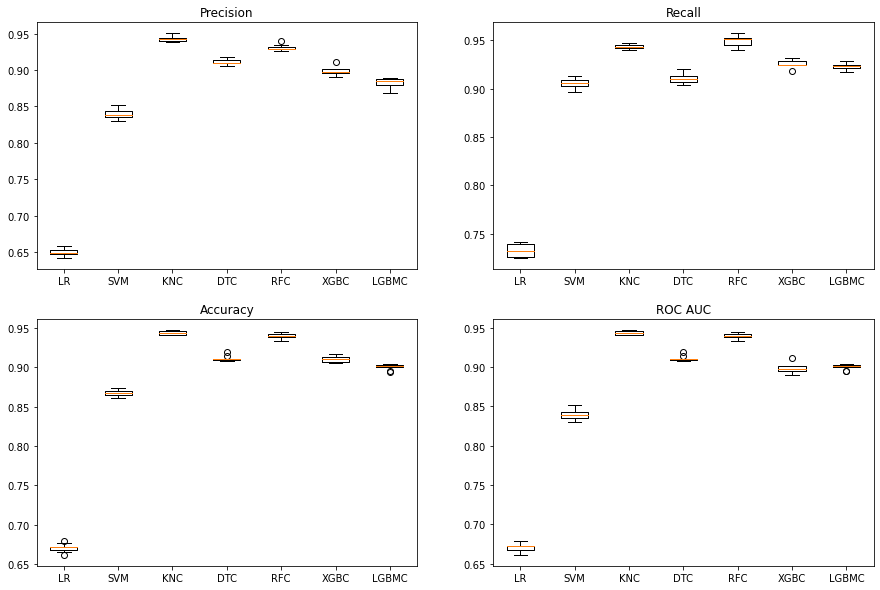

In [22]:
fig1, axes = plt.subplots(2,2)
fig1.set_size_inches(15, 10, forward=True)

axes[0][0].boxplot([fit_metrics_all['LogisticRegression']['precision'],
             fit_metrics_all['Support vector machine']['precision'],
             fit_metrics_all['KNeighborsClassifier']['precision'],
             fit_metrics_all['DecisionTreeClassifier']['precision'],
             fit_metrics_all['RandomForestClassifier']['precision'],
             fit_metrics_all['XGBClassifier']['precision'],
             fit_metrics_all['LGBMClassifier']['precision']],
            labels=['LR', 'SVM', 'KNC', 'DTC', 'RFC', 'XGBC', 'LGBMC'])
axes[0][0].set_title('Precision')

axes[0][1].boxplot([fit_metrics_all['LogisticRegression']['recall'],
             fit_metrics_all['Support vector machine']['recall'],
             fit_metrics_all['KNeighborsClassifier']['recall'],
             fit_metrics_all['DecisionTreeClassifier']['recall'],
             fit_metrics_all['RandomForestClassifier']['recall'],
             fit_metrics_all['XGBClassifier']['recall'],
             fit_metrics_all['LGBMClassifier']['recall']],
            labels=['LR', 'SVM', 'KNC', 'DTC', 'RFC', 'XGBC', 'LGBMC'])
axes[0][1].set_title('Recall')

axes[1][0].boxplot([fit_metrics_all['LogisticRegression']['accuracy'],
             fit_metrics_all['Support vector machine']['accuracy'],
             fit_metrics_all['KNeighborsClassifier']['accuracy'],
             fit_metrics_all['DecisionTreeClassifier']['accuracy'],
             fit_metrics_all['RandomForestClassifier']['accuracy'],
             fit_metrics_all['XGBClassifier']['accuracy'],
             fit_metrics_all['LGBMClassifier']['accuracy']],
            labels=['LR', 'SVM', 'KNC', 'DTC', 'RFC', 'XGBC', 'LGBMC'
                      ])
axes[1][0].set_title('Accuracy')

axes[1][1].boxplot([fit_metrics_all['LogisticRegression']['roc_auc'],
             fit_metrics_all['Support vector machine']['precision'],
             fit_metrics_all['KNeighborsClassifier']['roc_auc'],
             fit_metrics_all['DecisionTreeClassifier']['roc_auc'],
             fit_metrics_all['RandomForestClassifier']['roc_auc'],
             fit_metrics_all['XGBClassifier']['precision'],
             fit_metrics_all['LGBMClassifier']['roc_auc']],
            labels=['LR', 'SVM', 'KNC', 'DTC', 'RFC', 'XGBC', 'LGBMC'])
axes[1][1].set_title('ROC AUC')

Из-за масштабов данных график теряет в информативности, но видно что дсипесия всех метрик у всех классификаторв низкая. Следовательно, предсказания будут достаточно стабильными.

params={'n_estimators': 43, 'max_depth': 50} для случайного леса
params={'num_leaves': 95, 'n_estimators': 282, 'reg_alpha': 0.6255383522972234, 'reg_lambda': 0.3722415646228666} для LGBM